In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

In [3]:
# Load and explore data
df = pd.read_csv("cookie_cats.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
userid            90189 non-null int64
version           90189 non-null object
sum_gamerounds    90189 non-null int64
retention_1       90189 non-null bool
retention_7       90189 non-null bool
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


## 1. Data exploration

The dataset includes observations from 2 groups: gate_30 and gate_40. Gate_30 is considered control group and gate_40 is test group

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64


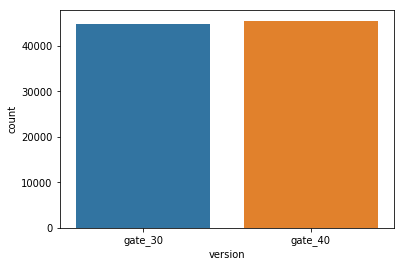

In [8]:
# Number of players in each groups
count_by_version = df.groupby(["version"]).count()["userid"]
print(count_by_version)
sns.countplot(x = "version", data = df)

In [16]:
# Statistic summary of gamerounds
df.groupby("version")["sum_gamerounds"].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


As in the summary, the mean values of 2 groups is about the same, as well as their min, 25 50 75 percentile. There are outliers who played up to 49000 rounds in control group and 2600 rounds in test group. However, there are only 2 rare cases like that.

In [36]:
# Counting the number of players for each number of gamerounds
count_df = pd.DataFrame(df.groupby("sum_gamerounds")["userid"].count())
count_df.head()

,userid
sum_gamerounds,
0,3994
1,5538
2,4606
3,3958
4,3629


### 1.1 Plot distribution of game rounds

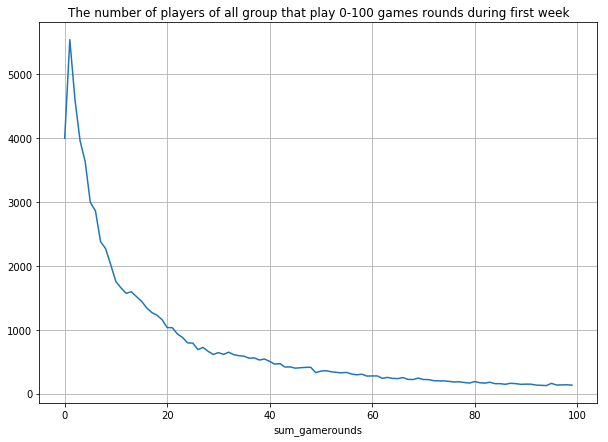

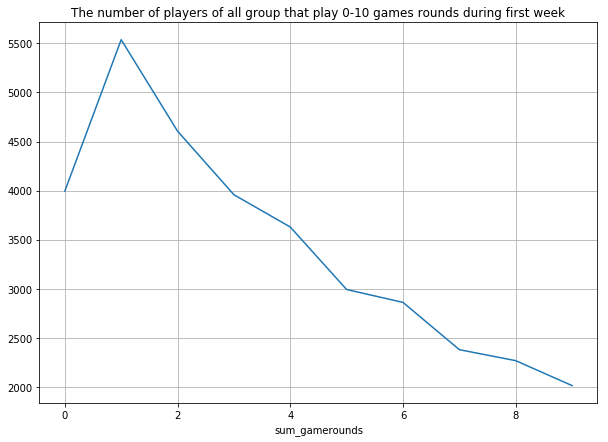

In [19]:
# Create general plot function
def sum_gamerounds_distribution(subset,title,plotscope):
    ax= subset.groupby("sum_gamerounds")["userid"].count()[:plotscope].plot(grid= True,figsize = (10,7))
    ax.set_title("The number of players of {} group that play 0-{} games rounds during first week".format(title,plotscope))
    plt.show()
    
    
sum_gamerounds_distribution(df, "all", 100)
sum_gamerounds_distribution(df, "all", 10)


In [17]:
#Subset data by groups
gate_40= df[df["version"] == "gate_40"]
gate_30= df[df["version"] == "gate_30"]

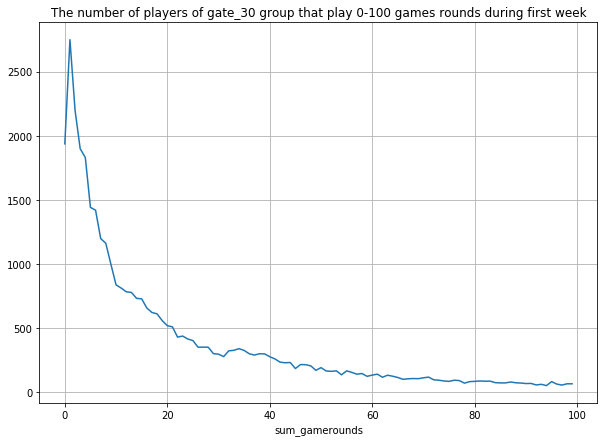

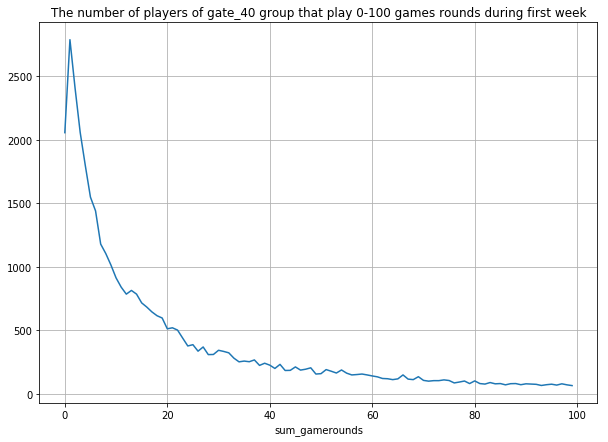

In [20]:
sum_gamerounds_distribution(gate_30, "gate_30", 100)
sum_gamerounds_distribution(gate_40, "gate_40", 100)

* Generally, there are total about 4000 players who play 0 round from the game.

* The distributions of two group look alike. More importantly, there is a skewed of the distribution until round 20 in both groups. Until round 60, the distribution seem to be steady

* Somehow, this is a signal that the retention of players is quite sensitive to number of rounds they played.

# 2. Calculate retention rate

In [21]:
def retention_rate(subset,days_of_retention):
    rate = subset[days_of_retention].sum()/subset[days_of_retention].count()*100
    return rate

### 2.2 General retention rate

In [22]:
print("General retention rate after 1 day is {:.2f} %".format(retention_rate(df, "retention_1")))
print("General retention rate after 7 day is {:.2f} %".format(retention_rate(df, "retention_7")))


General retention rate after 1 day is 44.52 %
General retention rate after 7 day is 18.61 %


### 2.2 General retention rate by group

In [24]:
print("Retention rate by group Day 1")
print(retention_rate(df.groupby("version"), "retention_1"))

Retention rate by group Day 1
version
gate_30    44.818792
gate_40    44.228275
Name: retention_1, dtype: float64


In [25]:
print("Retention rate by group Day 7")
print(retention_rate(df.groupby("version"), "retention_7"))

Retention rate by group Day 7
version
gate_30    19.020134
gate_40    18.200004
Name: retention_7, dtype: float64


# 3. A/B testing the significant of the difference

### 3.1 T-test


*Hypothesis: The retention rate of control group (gate_30) is higher than test group (gate_40)*

In [26]:
def t_test(control_group, test_group,variable):
    t, p = stats.ttest_ind(
        control_group[variable].values,
                test_group[variable].values,equal_var=False)
    print("This is t-test result of the {} :\nt_value: {}\np_value: {}".format(variable,t, p))

In [29]:
t_test(gate_30,gate_40,"retention_1")

This is t-test result of the retention_1 :
t_value: 1.7840774867039824
p_value: 0.07441443713953834


From this p value (>0.05), the difference in retention rate Day 1 of 2 groups is not significant. Hypothesis is not supported

In [30]:
t_test(gate_30,gate_40,"retention_7")

This is t-test result of the retention_7 :
t_value: 3.164028946774232
p_value: 0.001556530181006652


From this p value (<0.05), the difference in retention rate Day 7 of 2 groups is significant. Hence we can conclude that the gate_30 performs better 

### 3.2 Boostrap resampling to evaluate the difference

As it's shown in retention rate above, gate_30 performs better than gate_40. To make sure the certainty of this result, we might need to repeat the process with many samples. The mean value from boostrap resamples would show significant values

#### Boostrap resampling retention day 1

In [81]:
boot_1day = []  # Creating a list with bootstrapped means for each group

for i in range(4000): # repeat 4000 times for the process
    sample_mean = df.sample(frac = 0.4, replace = True).groupby("version")["retention_1"].mean() # sample size equal 40% of the pool
    boot_1day.append(sample_mean)

    

In [82]:
boot_1day = pd.DataFrame(boot_1day)

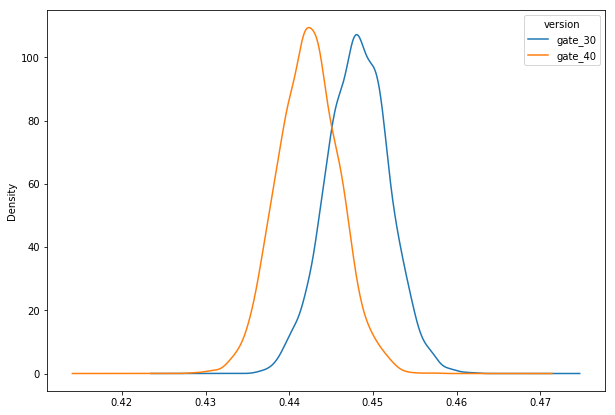

In [83]:
# Plot the distribution 
boot_1day.plot(kind = "density", figsize= (10,7))

As the distribution above, there is a difference in retention rate of control group (gate_30) and test group (gate_40). 
Next, we would calculate the differences between 2 groups and calculate the probability of that difference


In [84]:
# Calculate the difference between 2 Groups
boot_1day["difference"] = (boot_1day.gate_30 - boot_1day.gate_40)/boot_1day.gate_40*100

# Probability of the difference: 
prob_1day= (boot_1day['difference'] > 0).mean()*100
print("Probability that retention of gate 30 is higher than gate 40: {:.2f}%".format(prob_1day))

Probability that retention of gate 30 is higher than gate 40: 87.17%


#### Boostrap resampling retention day 7

In [87]:
boot_7day = []  # Creating a list with bootstrapped means for each group

for i in range(4000): # repeat 4000 times for the process
    sample_mean = df.sample(frac = 0.4, replace = True).groupby("version")["retention_7"].mean() # sample size equal 40% of the pool
    boot_7day.append(sample_mean)

boot_7day = pd.DataFrame(boot_7day)

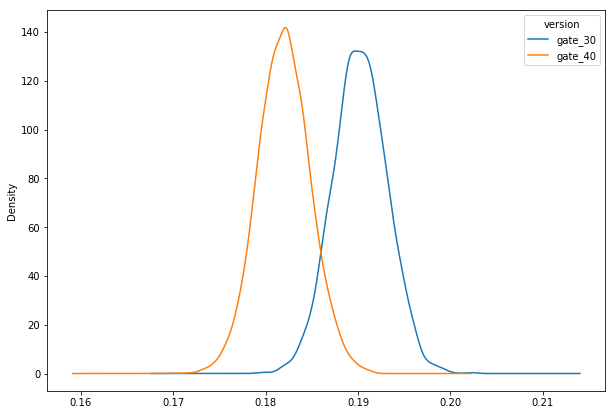

In [88]:
# Plot the distribution 
boot_7day.plot(kind = "density", figsize= (10,7))

Similarly, gate_30 show higher  average retention rate than gate_40

In [89]:
# Calculate the difference between 2 Groups
boot_7day["difference"] = (boot_7day.gate_30 - boot_7day.gate_40)/boot_7day.gate_40*100

# Probability of the difference: 
prob_7day= (boot_7day['difference'] > 0).mean()*100
print("Probability that retention of gate 30 is higher than gate 40: {:.2f}%".format(prob_7day))

Probability that retention of gate 30 is higher than gate 40: 97.78%
